In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

library(ggplot2)
library(data.table)

R[write to console]: data.table 1.17.0 usando 5 hilos (ver ?getDTthreads).  
R[write to console]: Últimas novedades: r-datatable.com

R[write to console]: **********
Ejecutando data.table en Español. El soporte del paquete está disponible solo en inglés. Cuando busque ayuda en línea, asegúrese de comprobar también el mensaje de error en inglés, examinando los archivos po/R-<locale>.po y po/<locale>.po en el código fuente del paquete. Allí se encuentran los mensajes de error en el idioma nativo y en inglés uno al lado del otro. You can also try calling Sys.setLanguage('en') prior to reproducing the error message.
**********



# Primate enrichment analyses

In [4]:
%%R


rhesus    <- fread("../Data/rhesus_plot_data_new.tsv")
chimp     <- fread("../Data/Chimp_plot_data.tsv")
orangutan <- fread("../Data/orangutan_plot_data.tsv")

human[, species := "Human"]
rhesus[, species := "Macaque"]
chimp[, species := "Chimp"]
orangutan[, species := "Orangutan"]


all_data <- rbind( rhesus, chimp, orangutan)

all_data[, adj_p_val := p.adjust(P_Value, method = "bonferroni")]

all_data[, significance := cut(adj_p_val,
                                 breaks = c(0, 0.001, 0.01, 0.05, 1),
                                 labels = c("***", "**", "*", "ns"))]


all_data[, Dist_threshold := factor(Dist_threshold,
                                     levels = c("No filter", "10000", "5000", "1000"))]

all_data[, species := factor(species, levels = rev(c("Macaque", "Orangutan", "Chimp"))) ]

        Type Dist_threshold Odds_Ratio      P_Value   species    adj_p_val
      <char>         <fctr>      <num>        <num>    <fctr>        <num>
 1:   Direct      No filter  1.1935378 5.081926e-02   Macaque 1.000000e+00
 2:   Direct          10000  1.1263307 2.253250e-01   Macaque 1.000000e+00
 3:   Direct           5000  1.0313933 7.823956e-01   Macaque 1.000000e+00
 4:   Direct           1000  1.2817159 4.637755e-01   Macaque 1.000000e+00
 5: Inverted      No filter  1.7777871 5.034755e-10   Macaque 1.208341e-08
 6: Inverted          10000  1.7417710 4.114588e-08   Macaque 9.875010e-07
 7: Inverted           5000  1.8158337 5.709927e-08   Macaque 1.370382e-06
 8: Inverted           1000  2.6628725 2.134374e-03   Macaque 5.122496e-02
 9:   Direct      No filter  0.9616254 6.691538e-01     Chimp 1.000000e+00
10:   Direct          10000  0.9566292 6.055331e-01     Chimp 1.000000e+00
11:   Direct           5000  0.9647132 7.314214e-01     Chimp 1.000000e+00
12:   Direct           10

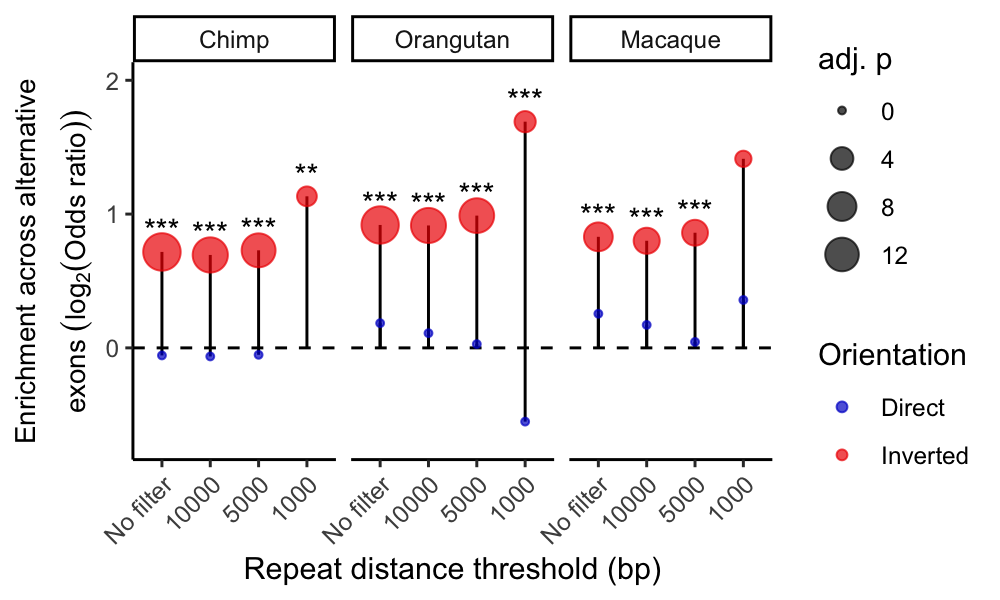

In [7]:
%%R -w 5 -h 3 --units in -r 200

Fig2A <- ggplot(all_data, aes(x = Dist_threshold, y = log2(Odds_Ratio))) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_segment(aes(x = Dist_threshold, xend = Dist_threshold, 
                   y = 0, yend = log2(Odds_Ratio)),
               color = "black", size = 0.5) +
  geom_point(aes(colour = Type, size = -log10(adj_p_val)), alpha = 0.7) +
  geom_text(data = subset(all_data, significance != "ns"),
            aes(label = significance),
            vjust = -0.5) +
  facet_grid( . ~ species ) +
  xlab("Repeat distance threshold (bp)") +
#   ylab(expression(atop("Ratio of alternative over constitutive", 
#                        "exon " * (log[2]("Odds ratio") ) )) ) +
  ylab(expression(atop("Enrichment across alternative", 
                       "exons " * (log[2]("Odds ratio") ) )) ) +
  ylim(c(-0.7, 2)) +
  scale_colour_manual(name = "Orientation",
                      values = c("Direct" = "blue3", "Inverted" = "red2")) +
  scale_size_continuous(name = "adj. p") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5),
        axis.title.y = element_text(size = 10), axis.text.x = element_text(angle = 45, hjust=1))

Fig2A

In [8]:
%%R 

mouse_conservation <- fread("../Data/mouse_conservation_plot_output.tsv")


mouse_conservation[ , adj_p_val:=p.adjust(P_Value, method = "bonferroni")]

mouse_conservation$significance <- cut(mouse_conservation$adj_p_val,
                                         breaks = c(0, 0.001, 0.01, 0.05, 1),
                                         labels = c("***", "**", "*", "ns"))





# Convert 'Dist_threshold' to a factor with the specified levels
mouse_conservation$Dist_threshold <- factor(mouse_conservation$Dist_threshold, 
                                              levels = c("No filter", "10000", "5000","1000"))

# Mouse constitutive to alternative transition

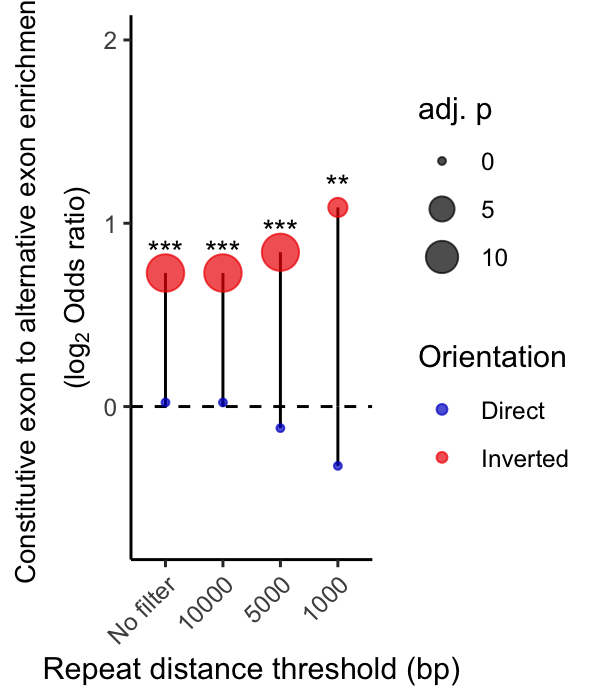

In [9]:
%%R -w 3 -h 3.5 --units in -r 200


ggplot(mouse_conservation) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  # vertical segments from y = 0 up to each log2(Odds_Ratio)
  geom_segment(aes(
      x = Dist_threshold,
      xend = Dist_threshold,
      y = 0,
      yend = log2(Odds_Ratio)
    ),
    color = "black",
    size = 0.5
  ) +
  
  # points colored by orientation, sized by –log10(adj_p_val)
  geom_point(aes(
      x = Dist_threshold,
      y = log2(Odds_Ratio),
      colour = Type,
      size = -log10(adj_p_val)
    ),
    alpha = 0.7
  ) +
  
  # significance labels (only non‐ns)
  geom_text(
    data = subset(mouse_conservation, significance != "ns"),
    aes(
      x = Dist_threshold,
      y = log2(Odds_Ratio),
      label = significance
    ),
    vjust = -0.5
  ) +
  
  # axis labels & limits
  xlab("Repeat distance threshold (bp)") +
  ylab(expression(atop(
    "Constitutive exon to alternative exon enrichment",
    "(log"[2]*" Odds ratio)"
  ))) +
  ylim(-0.7, 2) +
  
  # legends in desired order
  scale_colour_manual(
    name = "Orientation",
    values = c("Direct" = "blue3", "Inverted" = "red2"),
    guide = guide_legend(order = 2)
  ) +
  scale_size_continuous(
    name = "adj. p",
    guide = guide_legend(order = 1)
  ) +
  
  # classic theme + rotate x labels
  theme_classic() +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.title.y = element_text(size = 10),
    axis.text.x  = element_text(angle = 45, hjust = 1)
  )

# Primate pairwise comparisons

In [12]:
import csv
import gzip
import numpy as np
import pandas as pd
csv.field_size_limit(100000000)

131072

In [15]:
def get_fileterd_alu_pair_types(in_file):

    specie_pair_class = dict()

    with gzip.open(in_file, 'rt') as file:

        reader = csv.DictReader(file, delimiter='\t')

        for row in reader:

            total_pair_type = row['pair_type']

            if row['pair_type']=='None' or row['pair_type']=='':
                    
                    total_pair_type = 'None'

            specie_pair_class[(row['Event_ID'], "no_filter")] = total_pair_type

            dist_threholds = [50000, 10000, 5000, 1000]

            for t in dist_threholds:

                if total_pair_type== 'None':

                    specie_pair_class[(row['Event_ID'], t)] = total_pair_type

                else:

                    detected = set([])

                    if 'B_distance' in row:

                        for dist, alu_type in zip(row['B_distance'].split(","), row['pairing_types'].split("; ")):

                            if int(dist) <=t:
                                detected.add(alu_type)
                    
                    else:

                        for dist, alu_type in zip(row['Alu_distance'].split(","), row['pairing_types'].split("; ")):

                            if int(dist) <=t:
                                detected.add(alu_type)


                    if len(detected)==0:
                        filtered_pair_type = 'None'
                    
                    elif len(detected)==1:
                        filtered_pair_type = list(detected)[0]

                    elif len(detected)==2:
                        filtered_pair_type = 'mixed'

                    specie_pair_class[(row['Event_ID'], t)] = filtered_pair_type

    return specie_pair_class

In [11]:
def generate_pairwise_comparison_table(species_names, species_abbrevs, sp1_pair_class, sp2_pair_class, dist_thresholds=None):
    """
    Generate a pairwise PSI comparison table for two species.
    
    Parameters:
      species_names   : tuple of two species names (e.g., ("Macaque", "Human"))
                        These names will be used both to access the IDs in OrtIDs
                        and to prefix the output column names.
      species_abbrevs : tuple of two species abbreviations as used in the PSI data (e.g., ("mml", "hsa"))
      sp1_pair_class  : dictionary with pair classification for species_names[0] (e.g., macaque_pair_class)
                        Expected key: (ID, distance_threshold)
      sp2_pair_class  : dictionary with pair classification for species_names[1] (e.g., human_pair_class)
                        Expected key: (ID, distance_threshold)
      dist_thresholds : list of thresholds to iterate over; if None, defaults to ["no_filter", 50000, 10000, 5000, 1000]
    
    Returns:
      A pandas DataFrame with columns:
        ["Distance_Threshold", 
         "<species1>_ID", "<species1>_class", "<species1>_PSI",
         "<species2>_ID", "<species2>_class", "<species2>_PSI"]
    """
    
    if dist_thresholds is None:
        dist_thresholds = ["no_filter", 50000, 10000, 5000, 1000]
    
    results = []
    
    # Iterate over the paired entries from OrtIDs and OrtPSI
    for IDs, PSIs in zip(OrtIDs, OrtPSI):
        try:
            PSI_dict = {}
            # We collect tissues for species 1 and species 2 based on the abbreviations.
            tissues_sp1 = set()
            tissues_sp2 = set()
            
            for col, psi_val in PSIs.items():
                if col != "Exon":
                    # Assuming column names are formatted as "<abbrev>_<tissue>"
                    abbrev, tissue = col.split("_")
                    if psi_val != 'NA':
                        if abbrev == species_abbrevs[0]:
                            tissues_sp1.add(tissue)
                        elif abbrev == species_abbrevs[1]:
                            tissues_sp2.add(tissue)
                        PSI_dict[(abbrev, tissue)] = float(psi_val)
            
            # Consider only tissues that are present in both species.
            common_tissues = tissues_sp1.intersection(tissues_sp2)
            if not common_tissues:
                continue  # Skip entry if no common tissues
            
            sp1_PSI = [PSI_dict[(species_abbrevs[0], t)] for t in common_tissues]
            sp2_PSI = [PSI_dict[(species_abbrevs[1], t)] for t in common_tissues]
            
            # For each threshold, retrieve class information and compute mean PSI.
            for thr in dist_thresholds:
                sp1_ID = IDs[species_names[0]]
                sp2_ID = IDs[species_names[1]]
                sp1_class = sp1_pair_class[(sp1_ID, thr)]
                sp2_class = sp2_pair_class[(sp2_ID, thr)]
                
                results.append([
                    thr,
                    sp1_ID, sp1_class, np.mean(sp1_PSI) if sp1_PSI else np.nan,
                    sp2_ID, sp2_class, np.mean(sp2_PSI) if sp2_PSI else np.nan
                ])
        
        except KeyError:
            # Skip entries with missing keys.
            pass
    
    # Define the column names using the species_names tuple.
    columns = [
        "Distance_Threshold",
        species_names[0] + "_ID", species_names[0] + "_class", species_names[0] + "_PSI",
        species_names[1] + "_ID", species_names[1] + "_class", species_names[1] + "_PSI"
    ]
    
    res_df = pd.DataFrame(results, columns=columns)
    res_df["Distance_Threshold"] = res_df["Distance_Threshold"].astype(str)
    
    return res_df

In [ ]:
# Loading Nuno's data

OrtIDs = list()

with open('/Users/geparada/Downloads/EvoSplicePSI/OrthExcons_FullH.txt') as file:
    reader = csv.DictReader(file, delimiter='\t')

    for row in reader:
        OrtIDs.append(row)

OrtPSI = list()

with open('/Users/geparada/Downloads/EvoSplicePSI/PSI_All.txt') as file:
    reader = csv.DictReader(file, delimiter='\t')

    for row in reader:
        OrtPSI.append(row)

In [16]:
human_pair_class = get_fileterd_alu_pair_types("../Data/EvoPSI/hg19_human_exon_table_final.tsv.gz")
chimp_pair_class = get_fileterd_alu_pair_types("../Data/EvoPSI/pantro2_chimp_table_final2.tsv.gz")
orangutan_pair_class = get_fileterd_alu_pair_types("../Data/EvoPSI/ponabe2_orangutan_table_final.tsv.gz")
rhesus_pair_class = get_fileterd_alu_pair_types("../Data/EvoPSI/rhemac2_rhesus_table_final3.tsv.gz")
mouse_pair_class = get_fileterd_alu_pair_types("../Data/EvoPSI/mm9_mouse_final_table.tsv.gz")

In [18]:
human_chimp_res = generate_pairwise_comparison_table(("Human", "Chimp"), ("hsa", "ptr"), human_pair_class, chimp_pair_class)
human_orangutan_res = generate_pairwise_comparison_table(("Human", "Orangutan"), ("hsa", "ppy"), human_pair_class, orangutan_pair_class)
human_macaque_res = generate_pairwise_comparison_table(("Human", "Macaque"), ("hsa", "mml"), human_pair_class, rhesus_pair_class)
human_mouse_res = generate_pairwise_comparison_table(("Human", "Mouse"), ("hsa", "mmu"), human_pair_class, mouse_pair_class)

chimp_orangutan_res = generate_pairwise_comparison_table(("Chimp", "Orangutan"), ("ptr", "ppy"), chimp_pair_class, orangutan_pair_class)
chimp_macaque_res = generate_pairwise_comparison_table(("Chimp", "Macaque"), ("ptr", "mml"), chimp_pair_class, rhesus_pair_class)
chimp_mouse_res = generate_pairwise_comparison_table(("Chimp", "Mouse"), ("ptr", "mmu"), chimp_pair_class, mouse_pair_class)

orangutan_macaque_res = generate_pairwise_comparison_table(("Orangutan", "Macaque"), ("ppy", "mml"), orangutan_pair_class, rhesus_pair_class)
orangutan_mouse_res = generate_pairwise_comparison_table(("Orangutan", "Mouse"), ("ppy", "mmu"), orangutan_pair_class, mouse_pair_class)

macaque_mouse_res = generate_pairwise_comparison_table(("Macaque", "Mouse"), ("mml", "mmu"), rhesus_pair_class, mouse_pair_class)

## Ploting pairwise matrices 

In [26]:
%%R

library(ggplot2)
library(data.table)
library(ggrain)
library(tidyr)
library(ggsignif)
library(scales)


R[write to console]: Registered S3 methods overwritten by 'ggpp':
  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2



In [20]:
%%R -i human_chimp_res -i human_orangutan_res -i human_macaque_res -i human_mouse_res -i chimp_orangutan_res -i chimp_macaque_res -i chimp_mouse_res -i orangutan_macaque_res -i orangutan_mouse_res -i macaque_mouse_res

human_chimp_res <- data.table(human_chimp_res)
human_orangutan_res <- data.table(human_orangutan_res)
human_macaque_res <- data.table(human_macaque_res)
human_mouse_res <- data.table(human_mouse_res)

chimp_orangutan_res <- data.table(chimp_orangutan_res)
chimp_macaque_res <- data.table(chimp_macaque_res)
chimp_mouse_res <- data.table(chimp_mouse_res)

orangutan_macaque_res <- data.table(orangutan_macaque_res)
orangutan_macaque_res <- data.table(orangutan_macaque_res)

macaque_mouse_res <- data.table(macaque_mouse_res)

In [21]:

%%R

run_species_paired_wilcox <- function(dt, species, gain_filter) {
  # dt: the input table (data.table or coercible to one)
  # species: a character vector of length 2, e.g. c("Chimp", "Human")
  #          The first element will be filtered with _class=="None"
  #          and the second with _class=="inverted".
  
  # Ensure the input is a data.table.
  dt <- as.data.table(dt)
  
  # Construct column names using the supplied species names.
  sp1_class_col <- paste0(species[1], "_class")
  sp2_class_col <- paste0(species[2], "_class")
  
  sp1_PSI_col <- paste0(species[1], "_PSI")
  sp2_PSI_col <- paste0(species[2], "_PSI")
  
  # Filter the table:
  dt_filtered <- unique(dt[Distance_Threshold == "no_filter" &
                             get(sp1_class_col) == "None" &
                             get(sp2_class_col) == gain_filter &
                             !is.na(get(sp1_PSI_col)) &
                             !is.na(get(sp2_PSI_col))
                           ])
  
  # Run a paired Wilcoxon signed rank test on the specified PSI columns.
  test_result <- wilcox.test(dt_filtered[[sp1_PSI_col]], 
                             dt_filtered[[sp2_PSI_col]], 
                             paired = TRUE)
  
  # Return the p-value from the test.
  return(test_result$p.value)
}

In [22]:
%%R

species <- c("Human", "Chimp", "Orangutan", "Macaque", "Mouse")
ordering <- c("Human", "Chimp", "Orangutan", "Macaque", "Mouse")


# Helper function to determine the proper table name based on a custom ordering.
get_table_name <- function(s1, s2, ordering) {
  i1 <- match(s1, ordering)
  i2 <- match(s2, ordering)
  if (i1 < i2) {
    return(paste0(tolower(s1), "_", tolower(s2), "_res"))
  } else {
    return(paste0(tolower(s2), "_", tolower(s1), "_res"))
  }
}

# Helper function to order species according to the ordering vector.
get_ordered_species <- function(s1, s2, ordering) {
  i1 <- match(s1, ordering)
  i2 <- match(s2, ordering)
  if (i1 < i2) {
    return(c(s1, s2))
  } else {
    return(c(s2, s1))
  }
}

compute_pairwise_pvalues <- function(species, 
                                       ordering = c("Human", "Chimp", "Orangutan", "Macaque", "Mouse"),
                                       gain_filter = "inverted") {
  # Generate all ordered pairs (excluding self-pairs)
  pairs_df <- expand.grid(specie1 = species, specie2 = species, stringsAsFactors = FALSE)
  pairs_df <- pairs_df[pairs_df$specie1 != pairs_df$specie2, ]
  
  # For each pair, determine the proper table name based on the ordering.
  pairs_df$table_name <- mapply(get_table_name, pairs_df$specie1, pairs_df$specie2,
                                  MoreArgs = list(ordering = ordering))
  
  # For each pair, create a species vector using the original order.
  pairs_df$species_vector <- mapply(function(sp1, sp2) c(sp1, sp2), 
                                    pairs_df$specie1, pairs_df$specie2, 
                                    SIMPLIFY = FALSE)
  
  # For each row, retrieve the corresponding table and run the paired Wilcox test,
  # passing the gain_filter argument to run_species_paired_wilcox.
  pairs_df$p_value <- mapply(function(tblname, sp_vec) {
      dt <- get(tblname)
      run_species_paired_wilcox(dt, sp_vec, gain_filter)
    },
    pairs_df$table_name, pairs_df$species_vector)
  
  return(data.table(pairs_df))
}



In [23]:
%%R

species <- c("Human", "Chimp", "Orangutan", "Macaque", "Mouse")

# Compute the pairwise p-values:
pairwise_results.inverted <- compute_pairwise_pvalues(species, gain_filter="inverted")
pairwise_results.direct <- compute_pairwise_pvalues(species, gain_filter="direct")
pairwise_results.mixed <- compute_pairwise_pvalues(species, gain_filter="mixed")

pairwise_results.inverted <- pairwise_results.inverted[!species_vector %like% "Mouse", ]
pairwise_results.direct <-  pairwise_results.direct[!species_vector %like% "Mouse", ]
pairwise_results.mixed <- pairwise_results.mixed[!species_vector %like% "Mouse", ]

pairwise_results.inverted[, adj.p.val := p.adjust(p_value, method = "bonferroni")]
pairwise_results.direct[, adj.p.val := p.adjust(p_value, method = "bonferroni")]
pairwise_results.mixed[, adj.p.val := p.adjust(p_value, method = "bonferroni")]

      specie1   specie2            table_name    species_vector      p_value
       <char>    <char>                <char>            <list>        <num>
 1:     Chimp     Human       human_chimp_res       Chimp,Human 3.194572e-02
 2: Orangutan     Human   human_orangutan_res   Orangutan,Human 2.606518e-10
 3:   Macaque     Human     human_macaque_res     Macaque,Human 2.915725e-15
 4:     Human     Chimp       human_chimp_res       Human,Chimp 2.804709e-03
 5: Orangutan     Chimp   chimp_orangutan_res   Orangutan,Chimp 3.460889e-03
 6:   Macaque     Chimp     chimp_macaque_res     Macaque,Chimp 3.814451e-13
 7:     Human Orangutan   human_orangutan_res   Human,Orangutan 4.171852e-03
 8:     Chimp Orangutan   chimp_orangutan_res   Chimp,Orangutan 4.577780e-02
 9:   Macaque Orangutan orangutan_macaque_res Macaque,Orangutan 1.691296e-09
10:     Human   Macaque     human_macaque_res     Human,Macaque 1.974992e-03
11:     Chimp   Macaque     chimp_macaque_res     Chimp,Macaque 9.938214e-02

In [24]:
%%R



plot_pairwise_dot <- function(result_df, plot_title = "Pairwise Adjusted p-values Dot Plot") {
  # Ensure the input is a data.table.
  dt <- as.data.table(result_df)
  
  # Set any adj.p.val below 1e-16 to 1e-16.
  dt[, adj.p.val := ifelse(adj.p.val < 1e-16, 1e-16, adj.p.val)]
  
  # Create a new column for -log10(adj.p.val)
  dt[, logp := -log10(adj.p.val)]
  
  # Define the desired species order.
  order_vec <- c("Human", "Chimp", "Orangutan", "Macaque", "Mouse")
  
  # Convert specie1 and specie2 to factors with the specified order.
  dt[, specie1 := factor(specie1, levels = order_vec)]
  dt[, specie2 := factor(specie2, levels = order_vec)]
  
  # Create a new column for dot color: "firebrick" if adj.p.val < 0.05, otherwise "gray".
  dt[, dot_color := ifelse(adj.p.val < 0.05, "firebrick", "gray")]

  dt[, size_val := rescale(logp, to = c(1, 16))]
  
  # Build the dot plot matrix.
  p <- ggplot(dt, aes(x = specie2, y = specie1)) +
    geom_point(aes(size = logp, color = dot_color)) +
    scale_color_identity() +  # Use the exact color specified in dot_color.
    scale_size_continuous(name = "-log10(adj.p.val)",
                          range = c(1, 10),       # Fixed dot size range
                          limits = c(0, 16)) +  # Reference points every 4 units 
    #scale_size(range = c(0,5)) +              
    labs(y = "Without Alu pair", 
         x = "With mixed Alu pairs", 
         title = plot_title) +
    theme_minimal() +
    coord_fixed() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), 
          plot.title = element_text(hjust = 0.5))
  
  return(p)
}

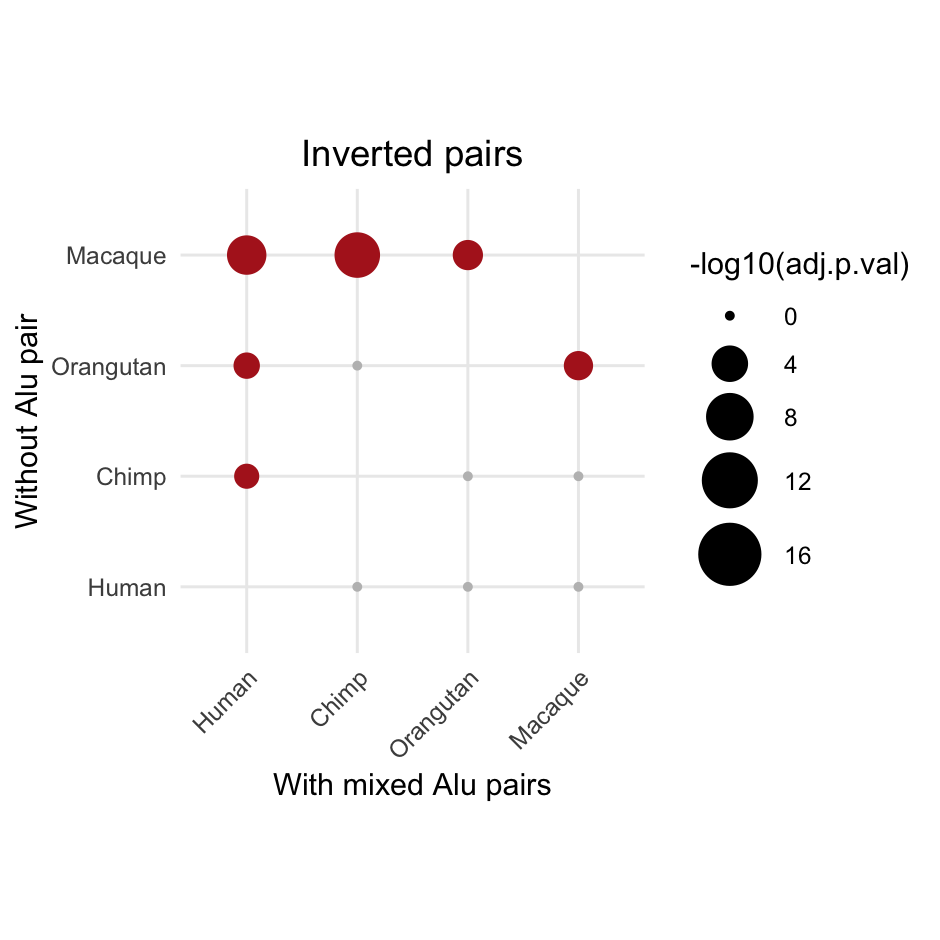

In [33]:
%%R -w 4.7 -h 4.7 --units in -r 200

pairwise_inverted <- plot_pairwise_dot(pairwise_results.inverted, "Inverted pairs")
pairwise_inverted

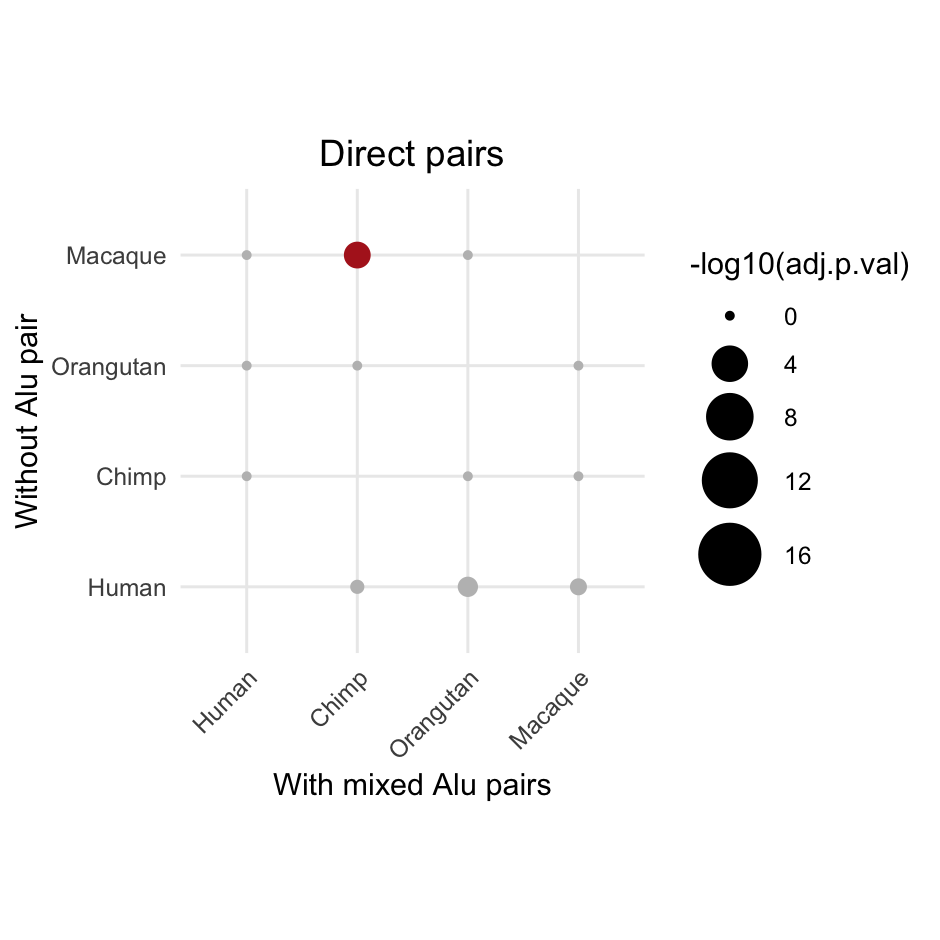

In [32]:
%%R -w 4.7 -h 4.7 --units in -r 200

pairwise_direct <- plot_pairwise_dot(pairwise_results.direct, "Direct pairs")
pairwise_direct

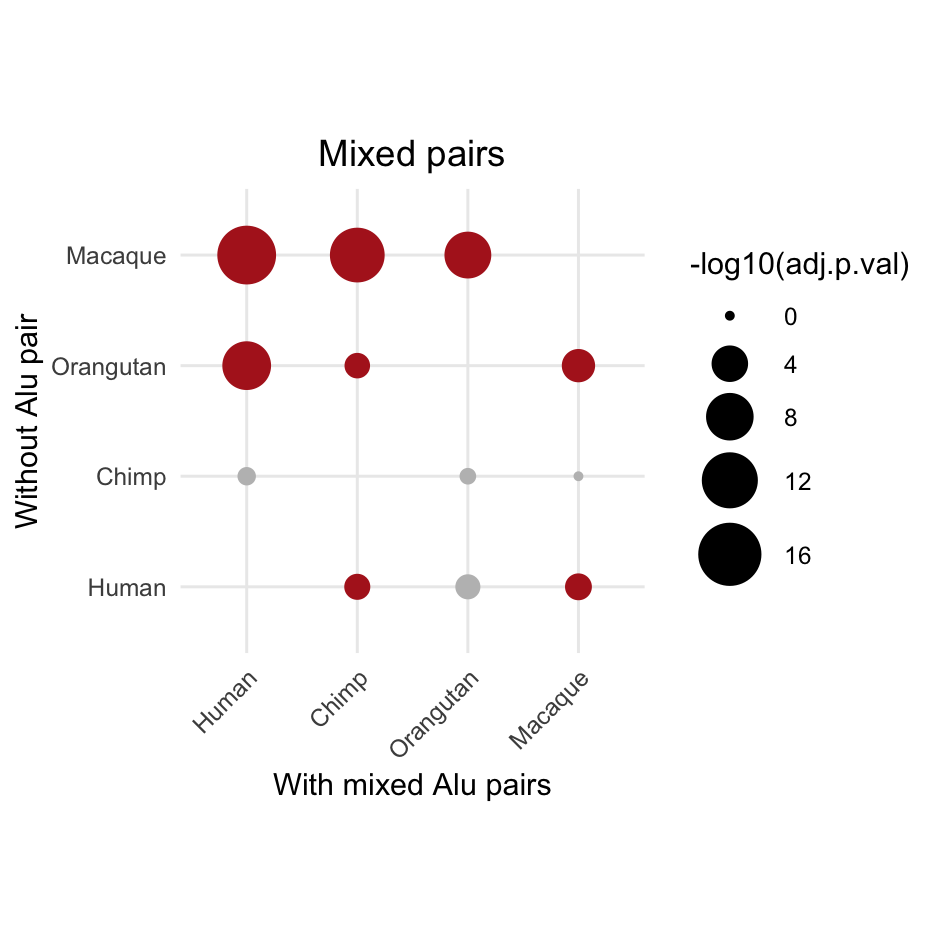

In [31]:
%%R -w 4.7 -h 4.7 --units in -r 200

plot_pairwise_dot(pairwise_results.mixed, "Mixed pairs")

# Human macaque comparison

In [34]:
%%R

plot_specie_pair_facet <- function(data_list, table_names, 
                                   species_pair = c("Human", "Macaque"), 
                                   psi_suffix = "_PSI", 
                                   custom_sig) {
  # Check inputs:
  if (length(data_list) != 2) stop("data_list must be a list of 2 tables")
  if (length(table_names) != 2) stop("table_names must be a character vector of length 2")
  if (length(custom_sig) != 2) stop("custom_sig must be a character vector of length 2")
  
  # Convert each table to data.frame (if not already) and add a table_name column.
  df_list <- lapply(seq_along(data_list), function(i) {
    df <- as.data.frame(data_list[[i]])
    df$table_name <- table_names[i]
    return(df)
  })
  
  # Merge the tables into one data.frame.
  combined <- do.call(rbind, df_list)
  
  # Add an id column for pairing information.
  combined$id <- seq_len(nrow(combined))
  
  # Construct the expected PSI column names.
  psi_cols <- paste0(species_pair, psi_suffix)
  
  # Reshape from wide to long format.
  combined_long <- pivot_longer(combined, 
                                cols = psi_cols,
                                names_to = "species",
                                values_to = "PSI")
  
  # Convert species into a factor so that the order follows species_pair.
  combined_long$species <- factor(combined_long$species, levels = psi_cols, labels = species_pair)
  
  # Compute a y-position for the significance annotation within each facet.
  # Here, for each table_name, we choose 5% above the maximum PSI value.
  y_positions <- aggregate(PSI ~ table_name, data = combined_long,
                           FUN = function(x) max(x, na.rm = TRUE) * 1.05)
  
  # Build the base plot with a facet grid.
  p <- ggplot(combined_long, aes(x = species, y = PSI, fill = species)) +
    geom_rain(alpha = 1, 
              point.args = list(alpha = 0.15),
              rain.side = "f2x2",
              id.long.var = "id") +
    theme_classic() +
    scale_fill_manual(values = c("dodgerblue", "darkorange")) +
    guides(fill = "none", color = "none") +
    xlab("") +
    facet_grid(. ~ table_name)
  
  # Add a geom_signif layer for each table facet.
  for(i in seq_along(table_names)) {
    curr_table <- table_names[i]
    # Extract the y-position computed for this facet.
    curr_y <- y_positions$PSI[y_positions$table_name == curr_table]
    curr_sig <- custom_sig[i]
    
    # Subset the combined_long data for this facet.
    sub_df <- combined_long[combined_long$table_name == curr_table, ]
    
    p <- p + geom_signif(data = sub_df,
                         comparisons = list(species_pair),
                         annotations = curr_sig,
                         y_position = curr_y,
                         tip_length = 0.01)
  }
  
  return(p)
}

In [37]:
%%R

human_orangutan_res.direct <- unique(human_orangutan_res[Distance_Threshold=='no_filter' & Orangutan_class=="None" & Human_class=="direct" & is.na(Orangutan_PSI)==F & is.na(Human_PSI)==F  ])
human_orangutan_res.inverted <- unique(human_orangutan_res[Distance_Threshold=='no_filter' & Orangutan_class=="None" & Human_class=="inverted" & is.na(Orangutan_PSI)==F & is.na(Human_PSI)==F  ])
human_orangutan_res.mixed <- unique(human_orangutan_res[Distance_Threshold=='no_filter' & Orangutan_class=="None" & Human_class=="mixed" & is.na(Orangutan_PSI)==F & is.na(Human_PSI)==F  ])

human_macaque_res.direct <- unique(human_macaque_res[Distance_Threshold=='no_filter' & Macaque_class=="None" & Human_class=="direct" & is.na(Macaque_PSI)==F & is.na(Human_PSI)==F  ])
human_macaque_res.inverted <- unique(human_macaque_res[Distance_Threshold=='no_filter' & Macaque_class=="None" & Human_class=="inverted" & is.na(Macaque_PSI)==F & is.na(Human_PSI)==F  ])
human_macaque_res.mixed <- unique(human_macaque_res[Distance_Threshold=='no_filter' & Macaque_class=="None" & Human_class=="mixed" & is.na(Macaque_PSI)==F & is.na(Human_PSI)==F  ])

chimp_macaque_res.direct <- unique(chimp_macaque_res[Distance_Threshold=='no_filter' & Macaque_class=="None" & Chimp_class=="direct" & is.na(Macaque_PSI)==F & is.na(Chimp_PSI)==F  ])
chimp_macaque_res.inverted <- unique(chimp_macaque_res[Distance_Threshold=='no_filter' & Macaque_class=="None" & Chimp_class=="inverted" & is.na(Macaque_PSI)==F & is.na(Chimp_PSI)==F  ])
chimp_macaque_res.mixed <- unique(chimp_macaque_res[Distance_Threshold=='no_filter' & Macaque_class=="None" & Chimp_class=="mixed" & is.na(Macaque_PSI)==F & is.na(Chimp_PSI)==F  ])


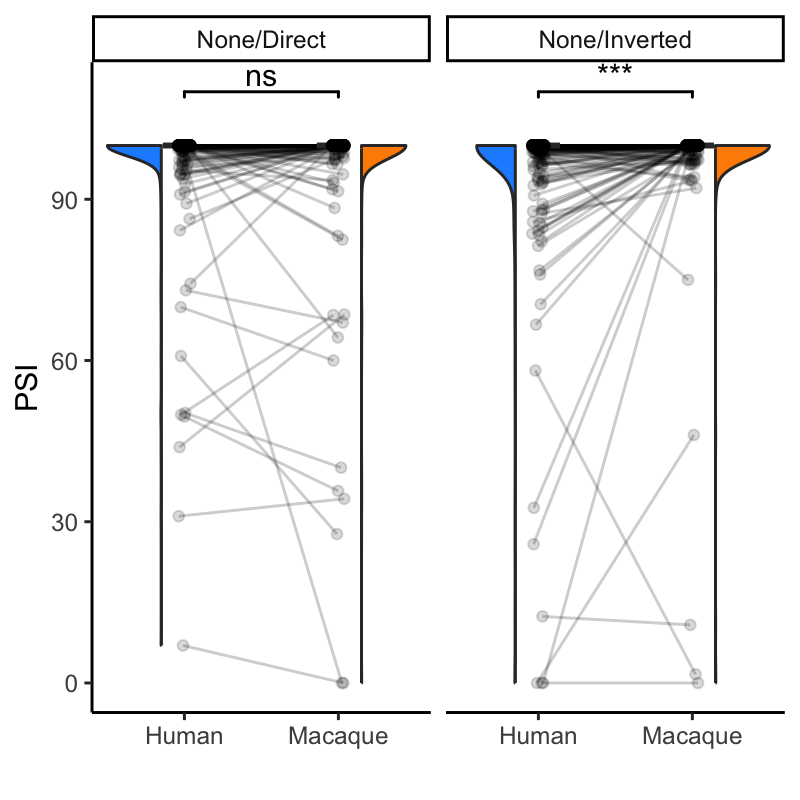

In [40]:
%%R -w 4 -h 4 --units in -r 200


plot_specie_pair_facet( list(  human_macaque_res.direct, human_macaque_res.inverted ), table_names=c("None/Direct", "None/Inverted"), species_pair = c("Human", "Macaque"), psi_suffix = "_PSI",  custom_sig=c("ns", "***") )

## Clearning artefacts

In [42]:
import glob